# Library Import

In [90]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import cv2
import tensorflow as tf
import tensorflow_datasets.public_api as tfds

In [91]:
pre_path = os.getcwd() #foe local machine 
#pre_path = '' #for Google Colab
pre_path

'c:\\Coding_Setup\\Fake-Logo Detection'

# Data Download

In [92]:
# _URL = 'http://image.ntua.gr/iva/datasets/flickr_logos/flickr_logos_27_dataset.tar.gz'
# zip_dir = tf.keras.utils.get_file(pre_path + '/logo', origin=_URL, untar=True,extract=True)

zip_dir = pre_path + '/logo'

# Data Extraction

In [93]:
import tarfile

fname = pre_path + '/logo.tar.gz'

if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()

In [94]:
fname = pre_path + '/flickr_logos_27_dataset/flickr_logos_27_dataset_images.tar.gz'

if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()

In [95]:
src_dir = "flickr_logos_27_dataset_images"
dest = "LOGOS"

if not os.path.exists(dest):
    os.makedirs(dest)

In [96]:
import pandas as pd
# from google.colab.patches import cv2_imshow

In [97]:
df = pd.read_csv( pre_path + "/flickr_logos_27_dataset/flickr_logos_27_dataset_training_set_annotation.txt", sep='\s+',header=None)

In [98]:
df

,0,1,2,3,4,5,6
0,144503924.jpg,Adidas,1,38,12,234,142
1,2451569770.jpg,Adidas,1,242,208,413,331
2,390321909.jpg,Adidas,1,13,5,89,60
3,4761260517.jpg,Adidas,1,43,122,358,354
4,4763210295.jpg,Adidas,1,83,63,130,93
...,...,...,...,...,...,...,...
4531,2126991906.jpg,Yahoo,6,15,6,253,54
4532,217288720.jpg,Yahoo,6,136,161,304,222
4533,2472817996.jpg,Yahoo,6,2,4,499,106
4534,2514220918.jpg,Yahoo,6,1,69,342,157


In [99]:
X = df.iloc[:,0]
Y = df.iloc[:,1]

In [100]:
dtdir = pre_path + '/flickr_logos_27_dataset_images/'

In [101]:
im = df[0][0]

In [102]:
size = df.iloc[:,3:]

In [103]:
size

,3,4,5,6
0,38,12,234,142
1,242,208,413,331
2,13,5,89,60
3,43,122,358,354
4,83,63,130,93
...,...,...,...,...
4531,15,6,253,54
4532,136,161,304,222
4533,2,4,499,106
4534,1,69,342,157


In [104]:
img = os.path.join(dtdir,im)

In [105]:
size = size.values.tolist()

In [106]:
size[0][0],size[0][1],size[0][2],size[0][3]

(38, 12, 234, 142)

In [107]:
image = cv2.imread(img)
# cv2_imshow(image)
image.shape

(210, 280, 3)

In [108]:
image = cv2.imread(img)
image = image[size[0][1]:size[0][3],size[0][0]:size[0][2]]
# cv2_imshow(image)
image.shape

(130, 196, 3)

In [109]:
query = pd.read_csv(pre_path + "/flickr_logos_27_dataset/flickr_logos_27_dataset_query_set_annotation.txt", sep='\s+',header=None)

In [110]:
query

,0,1
0,2403695909.jpg,Adidas
1,2912587920.jpg,Adidas
2,3441398196.jpg,Adidas
3,4605630935.jpg,Adidas
4,4606245138.jpg,Adidas
...,...,...
265,3480640208.jpg,none
266,3486224308.jpg,none
267,3486430785.jpg,none
268,3490185235.jpg,none


In [111]:
img = os.path.join(dtdir,query[0][5])
image = cv2.imread(img)
# cv2_imshow(image)
image.shape

(500, 437, 3)

In [112]:
testdist = 'TEST'

In [113]:
if not os.path.exists(testdist):
    os.makedirs(testdist)

In [114]:

y = list(set(list(Y)))
y.sort()

In [115]:
for i in y:
    os.makedirs(os.path.join(testdist,i))

In [116]:
for i in y:
    os.makedirs(os.path.join(dest,i))

In [117]:
distractor = pd.read_csv(pre_path + "/flickr_logos_27_dataset/flickr_logos_27_dataset_distractor_set_urls.txt", sep='\s+',header=None)

In [118]:
distractor

,0
0,http://farm2.static.flickr.com/1184/1013364004...
1,http://farm2.static.flickr.com/1108/1047095104...
2,http://farm2.static.flickr.com/1359/1076885577...
3,http://farm1.static.flickr.com/53/110432189_6d...
4,http://farm2.static.flickr.com/1144/1153048029...
...,...
4202,http://farm2.static.flickr.com/1254/889763557_...
4203,http://farm2.static.flickr.com/1308/901063602_...
4204,http://farm1.static.flickr.com/18/93551127_fed...
4205,http://farm2.static.flickr.com/1033/978252884_...


In [119]:
for i in range(len(X)):
    try:
        destrain = os.path.join(dest,Y[i])
        savepath = os.path.join(destrain,X[i])
        img  = os.path.join(dtdir,X[i])
        image = cv2.imread(img)
        image = image[size[i][1]:size[i][3],size[i][0]:size[i][2]]
        image = cv2.resize(image,(128,128))
        cv2.imwrite(savepath,image)
    except:
        print('error')
        pass

error
error
error
error
error


In [120]:
A = query.iloc[:,0]
B = query.iloc[:,1]

# Data Preprocessing

## Data Generation ( Augmentation Technique )

In [121]:
A

0      2403695909.jpg
1      2912587920.jpg
2      3441398196.jpg
3      4605630935.jpg
4      4606245138.jpg
            ...      
265    3480640208.jpg
266    3486224308.jpg
267    3486430785.jpg
268    3490185235.jpg
269    3490913574.jpg
Name: 0, Length: 270, dtype: object

In [122]:
HEIGHT = 224
WIDTH = 224

In [123]:

for i in range(len(A)):
    try:
        destrain = os.path.join(testdist,B[i])
        savepath = os.path.join(destrain,A[i])
        img  = os.path.join(dtdir,A[i])
        image = cv2.imread(img)
        image = cv2.resize(image,(WIDTH,HEIGHT))
        cv2.imwrite(savepath,image)
    except:
        print('error')
        pass


In [124]:
imagePaths = list(paths.list_images(testdist))

In [125]:
img = imagePaths[40]
print(img)
image = cv2.imread(img)
# cv2_imshow(image)
image.shape

TEST\Ford\106523337.jpg


(224, 224, 3)

In [126]:
train = ImageDataGenerator(
rescale = 1/255,
horizontal_flip=True,
vertical_flip=True,
shear_range=0.2,
zoom_range=0.2,
featurewise_center=True, # Set input mean to 0 over the dataset, feature-wise
featurewise_std_normalization=True, # Divide inputs by std of the dataset, feature-wise
rotation_range=40, # Degree range for random rotations
width_shift_range=0.2,
height_shift_range=0.2,
fill_mode='nearest',
validation_split = 0.2)

In [127]:
imagePaths = list(paths.list_images(dest))

In [128]:
os.makedirs('preview')

In [129]:
img = load_img(imagePaths[50])  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in train.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='yh', save_format='jpeg'):
    i += 1
    if i > 10:
        break  # otherwise the generator would loop indefinitely

c:\Users\adiuma5t\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\preprocessing\image.py:1863: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
c:\Users\adiuma5t\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\preprocessing\image.py:1873: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


In [130]:
image = cv2.imread(imagePaths[50])
# cv2_imshow(image)
image.shape

(128, 128, 3)

In [131]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

images = []
for img_path in glob.glob(pre_path + 'preview/*.jpeg'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)

<Figure size 2000x1000 with 0 Axes>

## Data Prepration ( Test & Train & Validation )

In [132]:
HEIGHT = 224
WIDTH = 224
INIT_LR = 1e-5
EPOCHS =  200
BS = 8

In [133]:
trainset = train.flow_from_directory(dest,
target_size = (WIDTH,HEIGHT),
batch_size = BS,
shuffle=False,
seed=42,
color_mode='rgb',
subset = 'training',
class_mode='categorical')

Found 648 images belonging to 27 classes.


In [134]:
validset = train.flow_from_directory(dest,
target_size = (WIDTH,HEIGHT),
batch_size = BS,
shuffle=False,
seed=42,
color_mode='rgb',
subset = 'validation',
class_mode='categorical')

Found 161 images belonging to 27 classes.


In [135]:
imagePaths = list(paths.list_images(dest))

In [136]:
trainset.filenames

['Adidas\\2534155497.jpg',
 'Adidas\\2550056374.jpg',
 'Adidas\\2553832700.jpg',
 'Adidas\\3005794070.jpg',
 'Adidas\\3007885565.jpg',
 'Adidas\\3294282629.jpg',
 'Adidas\\3308750600.jpg',
 'Adidas\\3541292073.jpg',
 'Adidas\\3732387125.jpg',
 'Adidas\\390321909.jpg',
 'Adidas\\4061203190.jpg',
 'Adidas\\4061203382.jpg',
 'Adidas\\4061675184.jpg',
 'Adidas\\4336482746.jpg',
 'Adidas\\4499338915.jpg',
 'Adidas\\451265524.jpg',
 'Adidas\\4605631045.jpg',
 'Adidas\\4761260517.jpg',
 'Adidas\\4763207899.jpg',
 'Adidas\\4763209871.jpg',
 'Adidas\\4763210295.jpg',
 'Adidas\\4763847308.jpg',
 'Adidas\\7787186.jpg',
 'Adidas\\791925651.jpg',
 'Apple\\2795236586.jpg',
 'Apple\\299768792.jpg',
 'Apple\\3006946827.jpg',
 'Apple\\3023420658.jpg',
 'Apple\\3065654531.jpg',
 'Apple\\3125626922.jpg',
 'Apple\\3187422169.jpg',
 'Apple\\3190306185.jpg',
 'Apple\\3261774945.jpg',
 'Apple\\339296129.jpg',
 'Apple\\3513049256.jpg',
 'Apple\\354643240.jpg',
 'Apple\\3652933741.jpg',
 'Apple\\3733440395.jpg

In [137]:
trainset.class_indices

{'Adidas': 0,
 'Apple': 1,
 'BMW': 2,
 'Citroen': 3,
 'Cocacola': 4,
 'DHL': 5,
 'Fedex': 6,
 'Ferrari': 7,
 'Ford': 8,
 'Google': 9,
 'HP': 10,
 'Heineken': 11,
 'Intel': 12,
 'McDonalds': 13,
 'Mini': 14,
 'Nbc': 15,
 'Nike': 16,
 'Pepsi': 17,
 'Porsche': 18,
 'Puma': 19,
 'RedBull': 20,
 'Sprite': 21,
 'Starbucks': 22,
 'Texaco': 23,
 'Unicef': 24,
 'Vodafone': 25,
 'Yahoo': 26}

# Model Building

In [138]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(WIDTH, HEIGHT, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(5, 5))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(trainset.num_classes, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
#sgd = SGD(lr=INIT_LR,momentum=0.9,nesterov=False)
model.compile(loss="categorical_crossentropy", optimizer='sgd',metrics=["accuracy"])
# train the head of the network

[INFO] compiling model...


In [139]:
totalTrain = len(list(paths.list_images(dest)))
totalTrain

809

# Model Training

In [141]:
# H = model.fit_generator(trainset,validation_data = validset,epochs=EPOCHS)

from tensorflow.keras.models import load_model
H = load_model('logo.model')

In [142]:
# # plot the training loss and accuracy
# N = EPOCHS
# plt.style.use("ggplot")
# plt.figure()
# plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
# plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
# plt.title("Training Loss VS Validation Loss")
# plt.xlabel("Epoch #")
# plt.ylabel("Loss/Accuracy")
# plt.legend(loc="lower left")
# plt.show()
# plt.savefig('graph.png')

In [143]:
# N = EPOCHS
# plt.style.use("ggplot")
# plt.figure()
# plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
# plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
# plt.title(" Accuracy")
# plt.xlabel("Epoch #")
# plt.ylabel("Accuracy")
# plt.legend(loc="lower left")
# plt.show()

# Model Testing

In [144]:
# reset the testing generator and then use our trained model to
# make predictions on the data
print("[INFO] evaluating after fine-tuning network...")
validset.reset()
predIdxs = model.predict(x=validset)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(validset.classes, predIdxs,
	target_names=validset.class_indices.keys()))
# serialize the model to disk
print("[INFO] serializing network...")
model.save('logo.model', save_format="h5")

[INFO] evaluating after fine-tuning network...
21/21 [==============================] - 3s 127ms/step
              precision    recall  f1-score   support

      Adidas       0.00      0.00      0.00         6
       Apple       0.00      0.00      0.00         6
         BMW       0.00      0.00      0.00         6
     Citroen       0.00      0.00      0.00         6
    Cocacola       0.00      0.00      0.00         6
         DHL       0.00      0.00      0.00         6
       Fedex       0.00      0.00      0.00         6
     Ferrari       0.00      0.00      0.00         6
        Ford       0.00      0.00      0.00         6
      Google       0.00      0.00      0.00         6
          HP       0.00      0.00      0.00         6
    Heineken       0.00      0.00      0.00         6
       Intel       0.00      0.00      0.00         6
   McDonalds       0.00      0.00      0.00         6
        Mini       0.00      0.00      0.00         6
         Nbc       0.00      0.00

c:\Users\adiuma5t\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\adiuma5t\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\adiuma5t\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [145]:
testimage = list(paths.list_images(pre_path + '/flickr_logos_27_dataset_images'))

In [146]:
model.get_config

<bound method Functional.get_config of <keras.engine.functional.Functional object at 0x000001D36D7F0C70>>

In [147]:
from PIL import Image
def predimage(path):
    image = Image.open(path)
    plt.imshow(image)
    test = load_img(path,target_size=(224,224))
    test = img_to_array(test)
    test = np.expand_dims(test,axis=0)
    test /= 255 
    result = model.predict(test,batch_size = BS)
    y_class = result.argmax(axis=-1)
    result = (result*100)
    result = list(np.around(np.array(result),1))
    print(result)
    print(y[y_class[0]])

1/1 [==============================] - 1s 565ms/step
[array([ 1.7,  1.4,  8.6,  0.9,  2. ,  0.3,  1.2,  1.1,  0.8,  1.8,  1.6,
        0.3,  1.1,  1.4,  4.6,  1.1,  2.1,  1.6,  2.6,  2.4,  3.5,  2.1,
        9.5,  3.3, 25.8, 15.1,  2.2], dtype=float32)]
Unicef


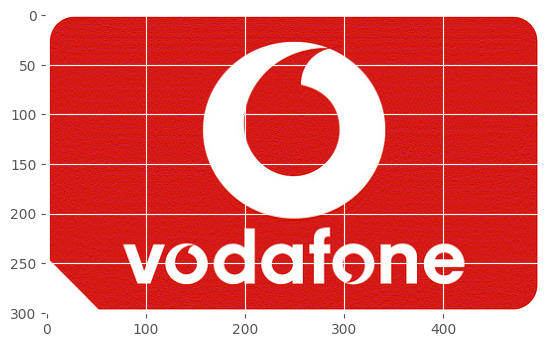

In [148]:
predimage(testimage[5])

1/1 [==============================] - 0s 48ms/step
[array([ 1.1,  1.4,  1.3,  1.6,  1.2,  0.2,  0.3,  8.6,  1.2,  1.4,  0.3,
        0. ,  0.5,  3.8,  1.5,  0.3,  2.7,  1.4,  3.7,  0.7,  0.7,  1.3,
        2.5,  2. , 28.4,  9.6, 22.4], dtype=float32)]
Unicef


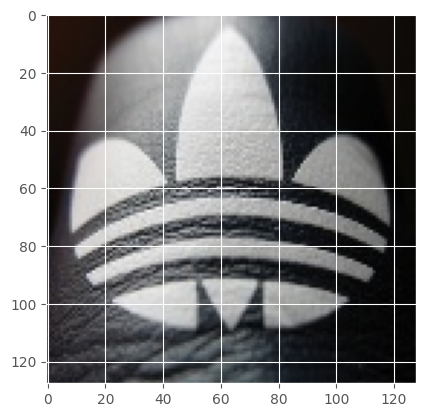

In [149]:
predimage(imagePaths[2])

1/1 [==============================] - 0s 56ms/step
[array([ 5. ,  0.7,  1.8,  0.5,  3.5,  0.1,  2. ,  1.3,  1.1,  2. ,  0.4,
        0.3,  1.1,  2.5,  4.4,  0.7,  3.5,  8.7,  1.8,  2. ,  3. ,  4.1,
        1.6,  0.8, 21.3, 12.1, 13.9], dtype=float32)]
Unicef


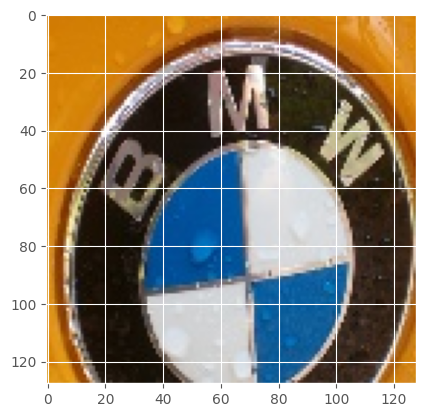

In [150]:
predimage(imagePaths[60])

1/1 [==============================] - 0s 42ms/step
[array([ 8. ,  3.1,  6.5,  0.8,  1.4,  0.5,  3.1, 10. ,  3.2,  3. ,  0.5,
        1.5,  0.9, 16.1,  1.2,  3.8,  6.7,  3.4,  4.3,  0.6,  0.6,  1.4,
        2.7,  0.8,  6.3,  6.3,  3.3], dtype=float32)]
McDonalds


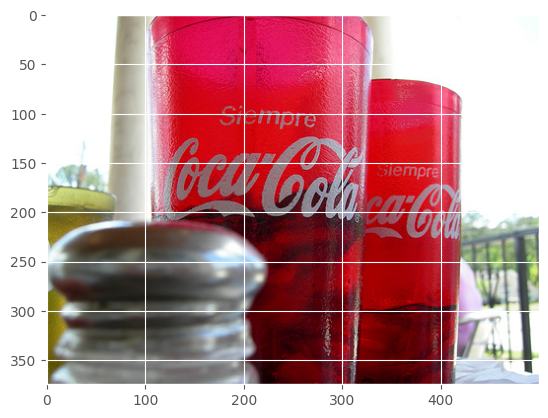

In [151]:
predimage(testimage[18])

# Model Dump in .pkl Format

In [152]:
# import pickle
# pickle.dump(H,open('model.pkl','wb'))

INFO:tensorflow:Assets written to: ram://40d2b6a5-5c04-407e-9f11-17a27e613e0c/assets


INFO:tensorflow:Assets written to: ram://40d2b6a5-5c04-407e-9f11-17a27e613e0c/assets
